## Importing libralries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from collections import Counter
import ast

## Loading and inspecting data

In [2]:

social_df = pd.read_csv('sentimentdataset.csv', index_col='User')
social_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries,  User123       to  VirtualTalentShowSuccessHighSchool 
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  732 non-null    int64 
 1   Unnamed: 0    732 non-null    int64 
 2   Text          732 non-null    object
 3   Sentiment     732 non-null    object
 4   Timestamp     732 non-null    object
 5   Platform      732 non-null    object
 6   Hashtags      732 non-null    object
 7   Retweets      732 non-null    int64 
 8   Likes         732 non-null    int64 
 9   Country       732 non-null    object
 10  Year          732 non-null    int64 
 11  Month         732 non-null    int64 
 12  Day           732 non-null    int64 
 13  Hour          732 non-null    int64 
dtypes: int64(8), object(6)
memory usage: 85.8+ KB


In [3]:
social_df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
User,,,,,,,,,,,,,,
User123,0,0,Enjoying a beautiful day at the park! ...,Positive,1/15/2023 12:30,Twitter,#Nature #Park,15,30,USA,2023,1,15,12
CommuterX,1,1,Traffic was terrible this morning. ...,Negative,1/15/2023 8:45,Twitter,#Traffic #Morning,5,10,Canada,2023,1,15,8
FitnessFan,2,2,Just finished an amazing workout! 💪 ...,Positive,1/15/2023 15:45,Instagram,#Fitness #Workout,20,40,USA,2023,1,15,15
AdventureX,3,3,Excited about the upcoming weekend getaway! ...,Positive,1/15/2023 18:20,Facebook,#Travel #Adventure,8,15,UK,2023,1,15,18
ChefCook,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,1/15/2023 19:55,Instagram,#Cooking #Food,12,25,Australia,2023,1,15,19


## Cleaning data

In [4]:
social_df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)
social_df.head()

,Text,Sentiment,Timestamp,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
User,,,,,,,,,,,,
User123,Enjoying a beautiful day at the park! ...,Positive,1/15/2023 12:30,Twitter,#Nature #Park,15,30,USA,2023,1,15,12
CommuterX,Traffic was terrible this morning. ...,Negative,1/15/2023 8:45,Twitter,#Traffic #Morning,5,10,Canada,2023,1,15,8
FitnessFan,Just finished an amazing workout! 💪 ...,Positive,1/15/2023 15:45,Instagram,#Fitness #Workout,20,40,USA,2023,1,15,15
AdventureX,Excited about the upcoming weekend getaway! ...,Positive,1/15/2023 18:20,Facebook,#Travel #Adventure,8,15,UK,2023,1,15,18
ChefCook,Trying out a new recipe for dinner tonight. ...,Neutral,1/15/2023 19:55,Instagram,#Cooking #Food,12,25,Australia,2023,1,15,19


In [5]:
# Define common country name mappings
country_replacements = {
    'Usa': 'United States',
    'U.S.A': 'United States',
    'United States Of America': 'United States',
    'Uk': 'United Kingdom',
    'Uae': 'United Arab Emirates',
    'South Korea': 'Korea, South',
    'Russia': 'Russian Federation',
    # Add more as needed
}

# Apply replacements after stripping and title-casing
social_df['Country'] = (
    social_df['Country']
    .str.strip()
    .str.title()
    .replace(country_replacements)
)


In [6]:
social_df_cleaned = social_df.copy()
social_df_cleaned['Sentiment'] = social_df_cleaned['Sentiment'].str.strip().str.capitalize()
social_df_cleaned['Platform'] = social_df_cleaned['Platform'].str.strip().str.capitalize()
social_df_cleaned['Hashtags'] = social_df_cleaned['Hashtags'].str.lower().str.replace('#', '').str.split()

sentiment_summary = social_df_cleaned.groupby(['Platform', 'Sentiment']).size().unstack().fillna(0)
sentiment_summary


Sentiment,Acceptance,Accomplishment,Admiration,Adoration,Adrenaline,Adventure,Affection,Amazement,Ambivalence,Amusement,...,Tranquility,Triumph,Vibrancy,Whimsy,Whispers of the past,Winter magic,Wonder,Wonderment,Yearning,Zest
Platform,,,,,,,,,,,,,,,,,,,,,
Facebook,4.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
Instagram,2.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,...,1.0,0.0,1.0,2.0,0.0,0.0,3.0,0.0,1.0,1.0
Twitter,2.0,0.0,2.0,2.0,0.0,3.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


## Visualise

In [7]:
social_df_cleaned['Polarity'] = social_df['Text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
social_df_cleaned['Subjectivity'] = social_df['Text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

# Categorize sentiment based on polarity
def categorizedSentiment(polarity):
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

social_df_cleaned['Sentiment_Category'] = social_df_cleaned['Polarity'].apply(categorizedSentiment)

textblob_path = 'categorizedSentiment.csv'
social_df_cleaned.to_csv(textblob_path, index=False)
textblob_summary = social_df_cleaned['Sentiment_Category'].value_counts()

textblob_summary


Sentiment_Category
Neutral     394
Positive    240
Negative     98
Name: count, dtype: int64

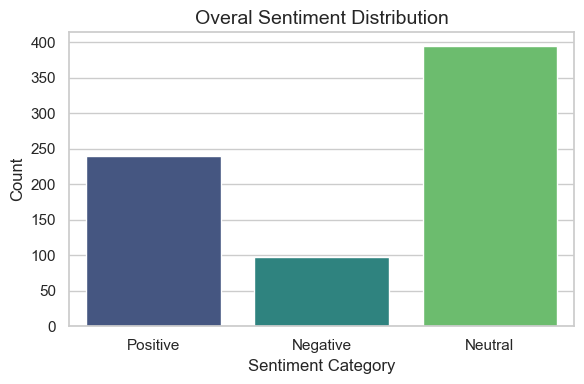

In [8]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(data=social_df_cleaned, x='Sentiment_Category', hue='Sentiment_Category', palette='viridis', legend=False)
plt.title('Overal Sentiment Distribution', fontsize=14)
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('Categorical_Sentiments_Count.png')
plt.show()


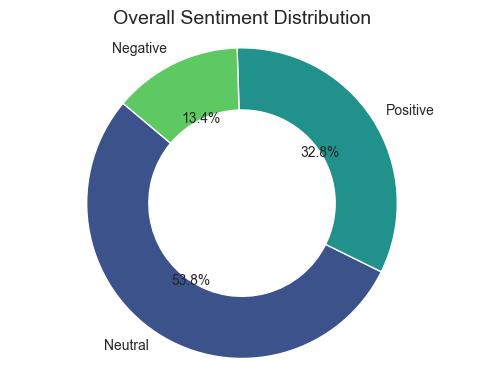

In [9]:
sentiment_counts = social_df_cleaned['Sentiment_Category'].value_counts()
labels = sentiment_counts.index
sizes = sentiment_counts.values
colors = sns.color_palette('viridis', len(labels))

plt.figure(figsize=(5, 4))
wedges, texts, autotexts = plt.pie(
    sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors,
    wedgeprops=dict(width=0.4, edgecolor='w'), textprops={'fontsize': 10}
)

plt.title('Overall Sentiment Distribution', fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.savefig('Sentiment_Distribution_DonutChart.png')
plt.show()


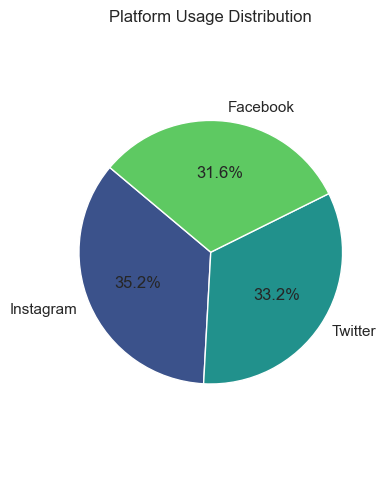

In [10]:
platform_counts = social_df_cleaned['Platform'].value_counts()
plt.figure(figsize=(4, 5))
colors = sns.color_palette('viridis', len(platform_counts))
plt.pie(platform_counts.values, labels=platform_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Platform Usage Distribution')
plt.axis('equal')
plt.tight_layout()
plt.savefig('Platform_Distribution_PieChart.png')
plt.show()


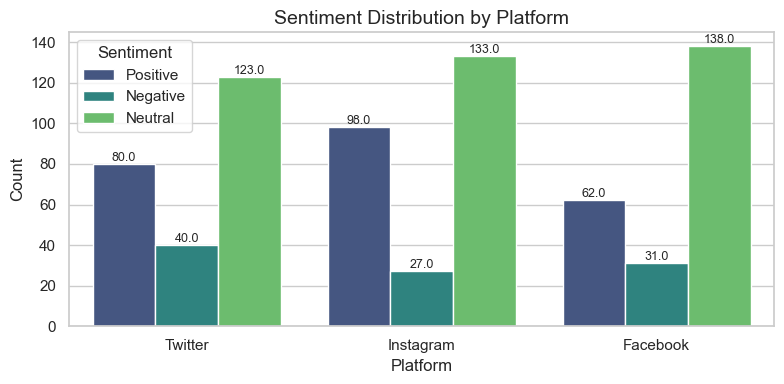

In [11]:
plt.figure(figsize=(8, 4))
sns.set_theme(style="whitegrid")

ax = sns.countplot(
    data=social_df_cleaned,
    x='Platform',
    hue='Sentiment_Category',
    palette='viridis'
)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9)

plt.title('Sentiment Distribution by Platform', fontsize=14)
plt.xlabel('Platform')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.savefig('Sentiment_by_Platform.png')
plt.show()


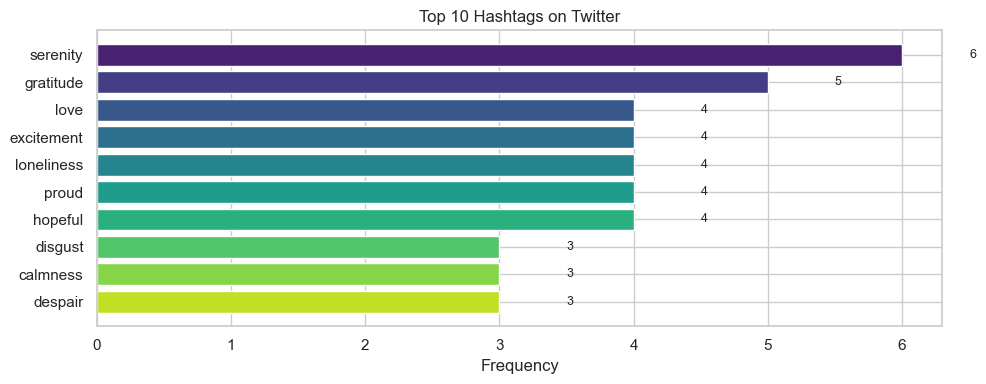

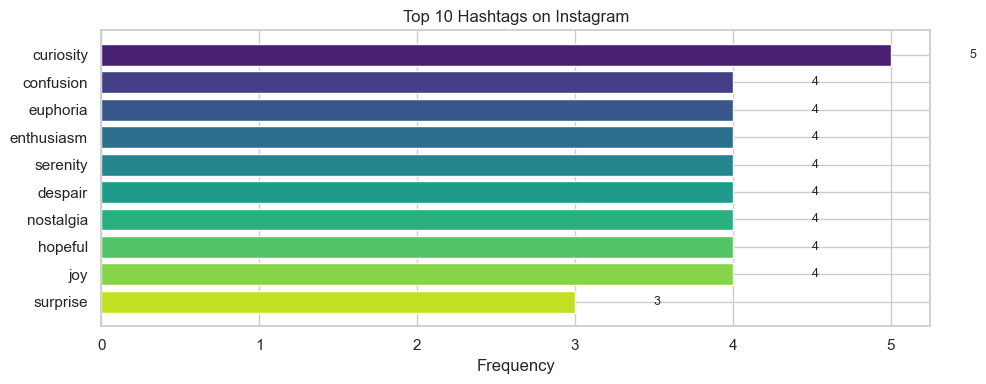

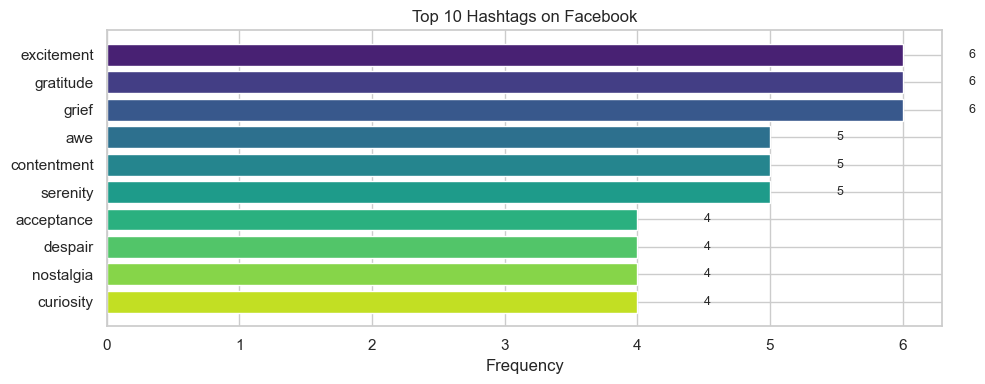

In [12]:
social_df_cleaned['Hashtags'] = (
    social_df_cleaned['Hashtags']
    .dropna()
    .apply(lambda x: [tag.strip().lower() for tag in str(x).split(',')])
)

exploded_df = social_df_cleaned.explode('Hashtags').dropna(subset=['Hashtags'])
exploded_df['Hashtags'] = exploded_df['Hashtags'].str.replace(r"[\'\"\[\]#]", '', regex=True)

platforms = exploded_df['Platform'].unique()

platform_hashtag_data = {}

for platform in platforms:
    platform_hashtags = exploded_df[exploded_df['Platform'] == platform]['Hashtags']
    hashtag_counts = Counter(platform_hashtags)
    top_10 = hashtag_counts.most_common(10)
    platform_hashtag_data[platform] = top_10

for platform, hashtags in platform_hashtag_data.items():
    if not hashtags:
        continue 
    labels, values = zip(*hashtags)
    colors = sns.color_palette("viridis", len(labels))

    plt.figure(figsize=(10, 4))
    bars = plt.barh(labels, values, color=colors)

    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, str(width), va='center', fontsize=9)

    plt.xlabel('Frequency')
    plt.title(f'Top 10 Hashtags on {platform}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(f'top_10_hashtags_{platform.lower().replace(" ", "_")}.png')
    plt.show()


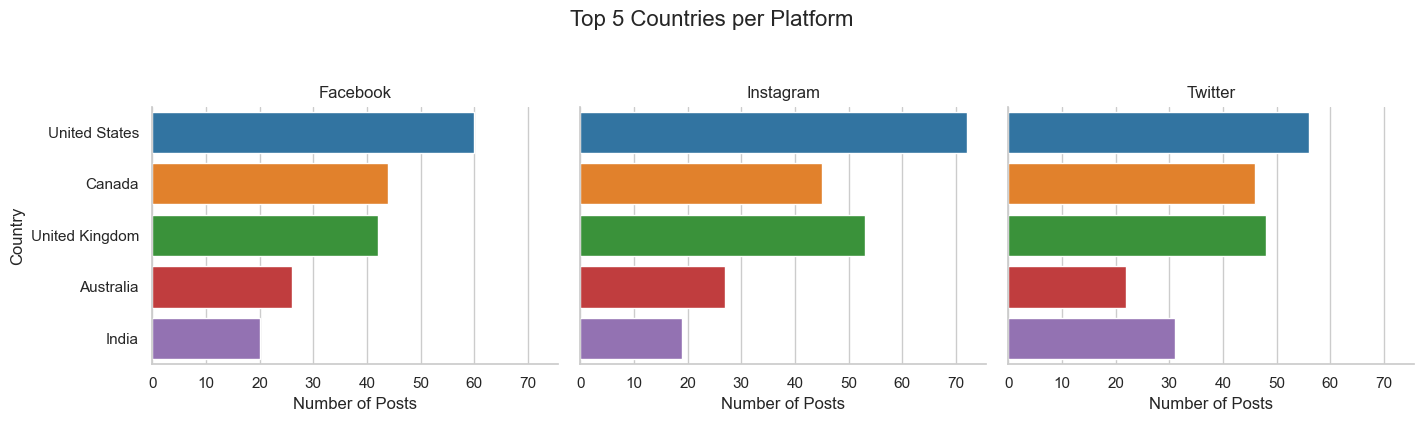

In [13]:
# Group by Platform and Country and count
country_platform_counts = (
    social_df_cleaned
    .groupby(['Platform', 'Country'])
    .size()
    .reset_index(name='Count')
)

# Top 5 countries per platform
top_countries_per_platform = (
    country_platform_counts
    .sort_values(['Platform', 'Count'], ascending=[True, False])
    .groupby('Platform')
    .head(5)
)

# Plot
g = sns.catplot(
    data=top_countries_per_platform,
    x='Count', y='Country',
    hue='Country',
    col='Platform',
    kind='bar',
    col_wrap=3,
    height=4,
    aspect=1.2,
    palette='tab10',
    legend=False,
)

g.set_titles("{col_name}")
g.set_axis_labels("Number of Posts", "Country")
g.fig.suptitle("Top 5 Countries per Platform", fontsize=16, y=1.05)
plt.tight_layout()
plt.savefig('Top_Countries_by_Platform.png')
plt.show()


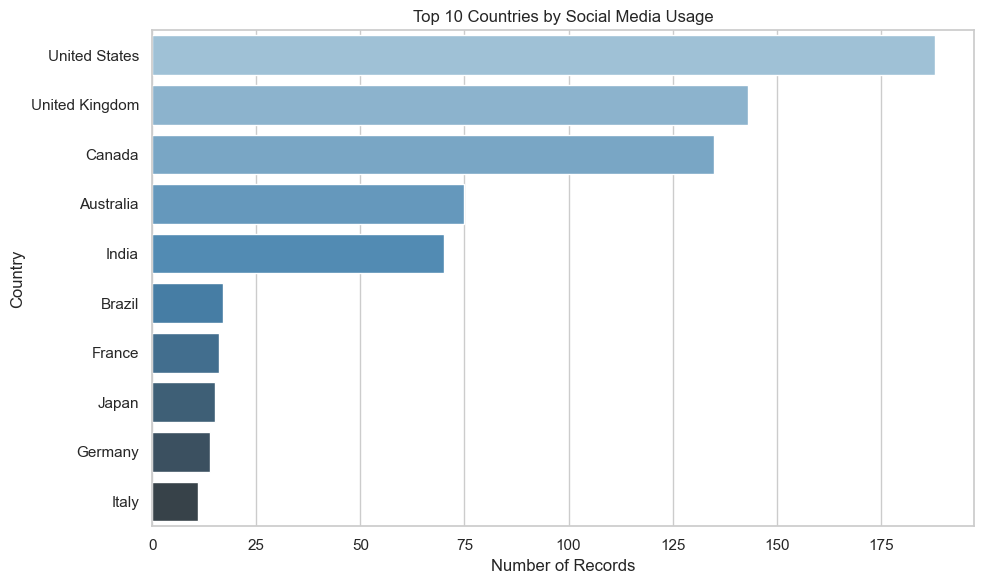

In [14]:
# Count the number of records per country
country_usage_counts = (
    social_df_cleaned['Country']
    .value_counts()
    .head(10)
    .reset_index()
)

country_usage_counts.columns = ['Country', 'UsageCount']


plt.figure(figsize=(10, 6))
sns.barplot(
    data=country_usage_counts,
    x='UsageCount', y='Country',
    hue='Country',
    palette='Blues_d',
    legend=False,
)
plt.title('Top 10 Countries by Social Media Usage')
plt.xlabel('Number of Records')
plt.ylabel('Country')
plt.tight_layout()
plt.show()


## Power BI Data

In [15]:

power_bi_df = pd.read_csv("categorizedSentiment.csv")
power_bi_df['Country'] = power_bi_df['Country'].str.strip().str.title()
power_data = power_bi_df.dropna(subset=['Hashtags']).copy()
power_bi_df['Hashtags'] = power_bi_df['Hashtags'].apply(ast.literal_eval)
df_exploded = power_bi_df.explode('Hashtags').reset_index(drop=True)

df_exploded.to_csv("power_bi_data.csv", index=False)

